# Informe Final Carrera

###### Disponible en: https://github.com/polo-edgard/ML

###### Para el proyecto final seleccioné como punto de partida, la resolución de los proyectos 01 y 02 que tienen como objetivo ayudar a los avaluadores de la empresa _Properati_ a valorar el precio de venta de las propiedades basado en las caractaerísticas/atributos de las propiedades.

##### Probé dos modelos adicionales que hasta el momento no había aplicado: `XGBoostRegressor` y `ExtraTreesRegressor`, los cuáles se pueden observar en la sección correspondiente de este notebook y se considera dejar los modelos anteriores para su comparación y los ajustes del análisis exploratorio relevantes para la optimización del dataset.

##### ¿Por qué seleccioné esos modelos?
##### Dentro de la gran variedad de modelos de regresión seleccioné las de un menor valor de **RMSE** obtenidos con una nueva librería conocida como `Lazy Predict` que ayuda a construir muchos modelos básicos sin mucho código y ayuda a comprender qué modelos funcionan mejor sin ningún ajuste de parámetros.

##### Los valores más bajos de RMSE indican un mejor ajuste. RMSE es una buena medida de la precisión con que el modelo predice la respuesta, y es el criterio más importante para ajustar si el propósito principal del modelo es la predicción de una variable continua como lo es el PRECIO.

##### En la actualidad _Properati_ usa: 
> "algoritmos desarrollados [...] que consideran características intrínsecas del inmueble (como el área y la cantidad de habitaciones) como aquellas relacionadas al contexto de la misma (el barrio y cercanía a lugares de interes general). Un rango de precios mas amplio indica una mayor variabilidad de precios en la zona donde esta ubicada la propiedad cuyo precio se desea estimar". 

##### Objetivo adicional (próximos pasos): Se deberá crear la interfaz de usuario (Front end) correspondiente que haga uso (consumo) del modelo que obtuvo el mejor resultado en la predicción del precio de las propiedades, que para nuestro caso fue _"Regresión lineal con atributos polinómicos"_, con esto pretendemos crear un formulario web de fácil uso que consulta los criterios de búsqueda (features) para generar el precio del avalúo.

### Artículos y referencias de interés consultados

* Visualize Missing Values with Missingno
https://towardsdatascience.com/visualize-missing-values-with-missingno-ad4d938b00a1

* Lazy Predict for ML Models
https://medium.com/swlh/lazy-predict-for-ml-models-c513a5daf792

* ExtraTreesRegressor - Python
https://www.kaggle.com/rahulvks/extratreesregressor-python

##### Dataset: Usaremos el mismo del Proyecto01 y Proyecto02 `DS_Proyecto_01_Datos_Properati.csv`

Ver entrega del Proyecto02 `DS_Proyecto_02-Edgard_Polo.ipynb` en:

(https://github.com/polo-edgard/ML/blob/main/DS_Proyecto_02-Edgard_Polo.ipynb)

Resultado de la evaluación de la entrega del Proyecto02:

(https://parrot.acamica.com/proyectos/30542/entrega?group=DS-ONLINE-26)

In [2]:
# Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import PolynomialFeatures, LabelBinarizer, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score

In [3]:
# Imagenes dentro del notebook
%matplotlib inline
# Configuración del tamaño de las figuras
plt.rcParams['figure.figsize'] = (12,8)
# Establecer opciones de pandas sobre las columnas y su ancho
pd.set_option('max_columns', 120)
pd.set_option('max_colwidth', 5000)

In [4]:
# Cargar el dataset
try:
    # Leer el dataset localmente 
    data = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')
    print("Dataset cargado desde recurso local")
except:
    #Leer el dataset desde un repositorio Google Drive (Aplica para uso del notebook en Colab)
    print("En caso de error recordar autenticarse con una cuenta Google para ejecutar el notebook en Colab \nEspere...")
    !pip install -U -q PyDrive ## you will have install for every colab session
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    import pandas as pd
    # 1. Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    # Compartir el dataset en Drive de Google y establecer el ID del archivo
    json_import = drive.CreateFile({'id':'1smd2MWqmav1y5shtc99hKEDC2SF8Nt9Q'}) #Si no se tiene acceso puede compartir su propio dataset y reemplazar el ID
    json_import.GetContentFile('DS_Proyecto_01_Datos_Properati.csv') # - leer el archivo compartido desde Google Drive
    data = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')
    print("Dataset cargado desde Google Drive")

Dataset cargado desde recurso local


In [5]:
# Número de filas y columnas del dataset
print("El dataset tiene {} filas".format(data.shape[0]))
print("El dataset tiene {} columnas".format(data.shape[1]))

El dataset tiene 146660 filas
El dataset tiene 19 columnas


In [6]:
# Primeras instancias
print("Las cinco primeras instancias son:")
data.head()

Las cinco primeras instancias son:


,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****","DESCRIPCION DE LA PROPIEDAD: Departamento de 140,65 metros cubiertos según escritura. Segundo piso por escalera. Dormitorios siete /",Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,"PH reciclado en Boedo a una cuadra de la plaza sin expensas, solo 4 propietarios en el edificio en muy buen estado.58 m2 cubiertos + 12 m2 de patioabajo: living comedor doble altura patio, toilette, cocina y lavaderoarriba: dormitorio con buen placard y baño completo.Impecable. Luz, sol y verde.Claudia Mascitti CMCPSI 6019",PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Palermo,"2 ambienets amplio , excelente estado , patio , cocina comedor . 45 mts. Migliorisi VE - Se deja constancia que las caracteristicas, medidas, expensas y superficies consignadas son aproximadas, sujetos a verificación y/o ajuste. El precio del inmueble puede ser modificado sin previo aviso. Fotos de carácter no contractual. Las unidades publicadas están sujetas a disponibilidad.",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH 2 AMBIENTES,"HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE RECICLADOS!!!LIVING/COMEDOR AL CONTRAFRENTE CON SALIDA A PATIO CON ADOQUINES Y PALMERA-DORMITORIO CON BALCON-COCINA Y BAÑO-TERRAZA//SUPER LUMINOSO Y CON EXCELENTE VENTILACION!!!ESTA UBICADO EN PLANTA BAJA, ES EL DEPTO DEL MEDIO POR PASILLOEXCELENTE UBICACION, DONDE NO SE PERMITEN LA CONSTRUCCION DE EDIFICIOS, POR LO QUE SE GARANTIZA EL AIRE Y EL SOL.APTO PROFESIONALNO PAGA EXPENSAS!!!Sup.Total: 85 MtsSup.Cub: 50 MtsSup.desc: 35 MtsSe deja constancia que las medidas (tanto totales como parciales), superficies, m2 y proporciones indicadas en el presente son aproximadas y sujetas a verificación, variación y/o ajuste. Las expensas pueden sufrir variaciones.",PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,"58 entre 1 y 2 Venta de departamento en ph.1 Dormitorio , La Plata","58 entre 1 y 2 Venta de departamento en PH. Primer piso por escaleras. Living comedor, cocina integrada, 1 dormitorio , baño con ducha, terraza de 15 metros, tipo de calefacción por tiro balanceado, ventilación cruzada, zona de facultades. SIN EXPENSAS",PH,Venta


In [7]:
# Nombre de las columnas
print("los nombres de las columnas son")
print(list(data.columns.values))

los nombres de las columnas son
['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'currency', 'title', 'description', 'property_type', 'operation_type']


### Eliminamos duplicados del dataframe en este punto antes de hacer cualquier transformación adicional

In [8]:
# Duplicados del DataFrame
print("El número de registros duplicados son: {}".format(data.duplicated().sum()))

El número de registros duplicados son: 2358


In [9]:
# Eliminamos registros duplicados
data = data.drop_duplicates()

### Valores Faltantes

In [10]:
# Valores faltantes por cada columna
missing_values_count = data.isnull().sum()
print("los valores faltantes de cada una de las columnas son")
print(missing_values_count[0:19])

los valores faltantes de cada una de las columnas son
start_date             0
end_date               0
created_on             0
lat                 9572
lon                 9606
l1                     0
l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           5924
surface_total      20261
surface_covered    21339
price                  0
currency               0
title                  0
description            0
property_type          0
operation_type         0
dtype: int64


<AxesSubplot:>

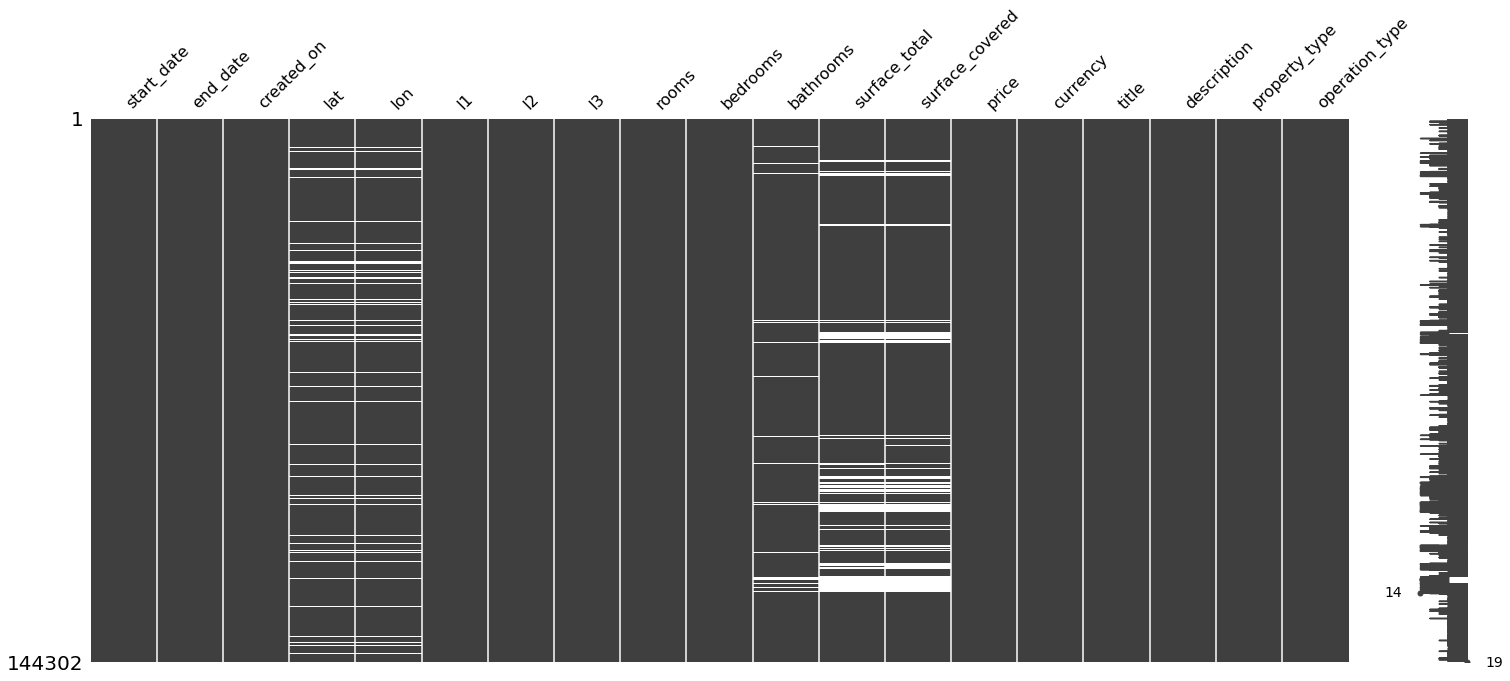

In [11]:
# Visualize Missing Values with Missingno
# !pip install missingno
msno.matrix(data)

In [12]:
# Porcentaje de valores faltantes
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
print("El porcentaje de valores faltantes sobre el total de los valores es de", round(total_missing / total_cells*100, 2), "%")

El porcentaje de valores faltantes sobre el total de los valores es de 2.43 %


In [13]:
# Tipos de propiedad
print("Hay {} tipos de propiedades".format(len(data["property_type"].unique())))
print ("Las cuáles son {}".format(list(data["property_type"].unique())))

Hay 10 tipos de propiedades
Las cuáles son ['Departamento', 'PH', 'Casa', 'Lote', 'Casa de campo', 'Oficina', 'Otro', 'Local comercial', 'Cochera', 'Depósito']


### Filtrando las categorías

In [14]:
# Creamos el nuevo Data Frame con los datos filtrados
df_filtered = pd.DataFrame(data.query('property_type in ["Departamento", "PH", "Casa"]'))

# Número de filas y columnas Data Frame con los datos filtrados
print("El dataset tiene {} filas".format(df_filtered.shape[0]))
print("El dataset tiene {} columnas".format(df_filtered.shape[1]))

El dataset tiene 140822 filas
El dataset tiene 19 columnas


<AxesSubplot:xlabel='property_type', ylabel='count'>

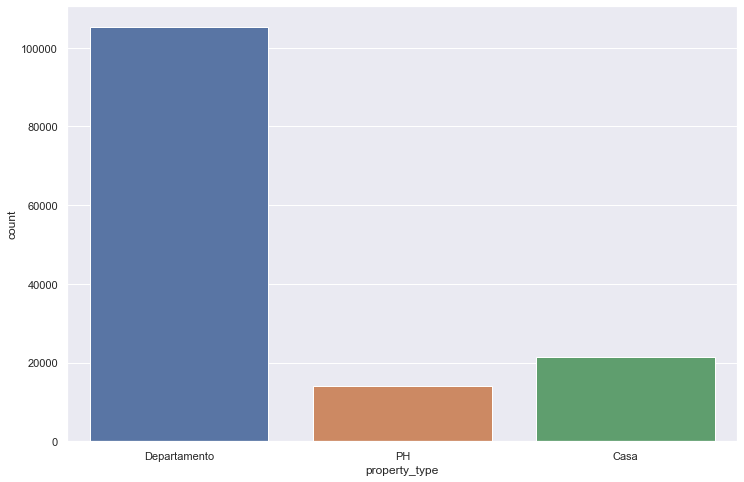

In [15]:
# Visualizá las categorías en esta celda

sns.set(style="darkgrid")
sns.countplot("property_type", data=df_filtered)

## PARTE A - Transformación de Datos

#### 1. Eliminamos del dataframe las instancias que no tengan ningún valor en los campos relevantes para el análisis del mercado `surface_total`, `rooms`, `surface_covered`, `price`.

In [16]:
df_filtered.dropna(subset=['surface_total', 'rooms', "surface_covered", "price" ], inplace = True)
# Número de filas y columnas Data Frame con los datos filtrados
print("El dataset tiene {} filas".format(df_filtered.shape[0]))
print("El dataset tiene {} columnas".format(df_filtered.shape[1]))
df_filtered.head()

El dataset tiene 121672 filas
El dataset tiene 19 columnas


,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****","DESCRIPCION DE LA PROPIEDAD: Departamento de 140,65 metros cubiertos según escritura. Segundo piso por escalera. Dormitorios siete /",Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,"PH reciclado en Boedo a una cuadra de la plaza sin expensas, solo 4 propietarios en el edificio en muy buen estado.58 m2 cubiertos + 12 m2 de patioabajo: living comedor doble altura patio, toilette, cocina y lavaderoarriba: dormitorio con buen placard y baño completo.Impecable. Luz, sol y verde.Claudia Mascitti CMCPSI 6019",PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Palermo,"2 ambienets amplio , excelente estado , patio , cocina comedor . 45 mts. Migliorisi VE - Se deja constancia que las caracteristicas, medidas, expensas y superficies consignadas son aproximadas, sujetos a verificación y/o ajuste. El precio del inmueble puede ser modificado sin previo aviso. Fotos de carácter no contractual. Las unidades publicadas están sujetas a disponibilidad.",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH 2 AMBIENTES,"HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE RECICLADOS!!!LIVING/COMEDOR AL CONTRAFRENTE CON SALIDA A PATIO CON ADOQUINES Y PALMERA-DORMITORIO CON BALCON-COCINA Y BAÑO-TERRAZA//SUPER LUMINOSO Y CON EXCELENTE VENTILACION!!!ESTA UBICADO EN PLANTA BAJA, ES EL DEPTO DEL MEDIO POR PASILLOEXCELENTE UBICACION, DONDE NO SE PERMITEN LA CONSTRUCCION DE EDIFICIOS, POR LO QUE SE GARANTIZA EL AIRE Y EL SOL.APTO PROFESIONALNO PAGA EXPENSAS!!!Sup.Total: 85 MtsSup.Cub: 50 MtsSup.desc: 35 MtsSe deja constancia que las medidas (tanto totales como parciales), superficies, m2 y proporciones indicadas en el presente son aproximadas y sujetas a verificación, variación y/o ajuste. Las expensas pueden sufrir variaciones.",PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,"58 entre 1 y 2 Venta de departamento en ph.1 Dormitorio , La Plata","58 entre 1 y 2 Venta de departamento en PH. Primer piso por escaleras. Living comedor, cocina integrada, 1 dormitorio , baño con ducha, terraza de 15 metros, tipo de calefacción por tiro balanceado, ventilación cruzada, zona de facultades. SIN EXPENSAS",PH,Venta


In [17]:
# Otros atributos con valores faltantes

print("Valores faltantes totales")
print(pd.isna(df_filtered).sum())

Valores faltantes totales
start_date            0
end_date              0
created_on            0
lat                8092
lon                8092
l1                    0
l2                    0
l3                    0
rooms                 0
bedrooms              0
bathrooms          1675
surface_total         0
surface_covered       0
price                 0
currency              0
title                 0
description           0
property_type         0
operation_type        0
dtype: int64


In [18]:
# Instancias que contienen errores en la superficie
wrong_surface_rows = df_filtered[df_filtered["surface_total"] < df_filtered["surface_covered"]]
print("Total de instancias con errores en la superficie:", wrong_surface_rows.shape[0])

Total de instancias con errores en la superficie: 1419


#### 2. Intercambiamos los valores de **superficie total** con **superficie cubierta** siempre que se cumpla la condición ya que pudo deberse a un error de digitación o interpretación

In [19]:
# Ajuste de valores de superficies en la columna que corresponde
df_filtered.at[wrong_surface_rows.index, 'surface_total'] = wrong_surface_rows.surface_covered
df_filtered.at[wrong_surface_rows.index, 'surface_covered'] = wrong_surface_rows.surface_total

# Instancias que contienen errores en la superficie
wrong_surface_rows = df_filtered[df_filtered["surface_total"] < df_filtered["surface_covered"]]
print("Total de instancias con errores en la superficie:", wrong_surface_rows.shape[0])

Total de instancias con errores en la superficie: 0


#### 3. Agregamos al dataset una nueva columna de precio en dólares por m2 

In [20]:
df_filtered['price_usd_x_m2'] = df_filtered['price'] / df_filtered['surface_total']
print("El dataset tiene {} filas".format(df_filtered.shape[0]))
print("El dataset tiene {} columnas".format(df_filtered.shape[1]))
df_filtered.head()

El dataset tiene 121672 filas
El dataset tiene 20 columnas


,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type,price_usd_x_m2
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****","DESCRIPCION DE LA PROPIEDAD: Departamento de 140,65 metros cubiertos según escritura. Segundo piso por escalera. Dormitorios siete /",Departamento,Venta,1092.857143
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,"PH reciclado en Boedo a una cuadra de la plaza sin expensas, solo 4 propietarios en el edificio en muy buen estado.58 m2 cubiertos + 12 m2 de patioabajo: living comedor doble altura patio, toilette, cocina y lavaderoarriba: dormitorio con buen placard y baño completo.Impecable. Luz, sol y verde.Claudia Mascitti CMCPSI 6019",PH,Venta,2271.428571
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Palermo,"2 ambienets amplio , excelente estado , patio , cocina comedor . 45 mts. Migliorisi VE - Se deja constancia que las caracteristicas, medidas, expensas y superficies consignadas son aproximadas, sujetos a verificación y/o ajuste. El precio del inmueble puede ser modificado sin previo aviso. Fotos de carácter no contractual. Las unidades publicadas están sujetas a disponibilidad.",PH,Venta,2777.777778
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH 2 AMBIENTES,"HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE RECICLADOS!!!LIVING/COMEDOR AL CONTRAFRENTE CON SALIDA A PATIO CON ADOQUINES Y PALMERA-DORMITORIO CON BALCON-COCINA Y BAÑO-TERRAZA//SUPER LUMINOSO Y CON EXCELENTE VENTILACION!!!ESTA UBICADO EN PLANTA BAJA, ES EL DEPTO DEL MEDIO POR PASILLOEXCELENTE UBICACION, DONDE NO SE PERMITEN LA CONSTRUCCION DE EDIFICIOS, POR LO QUE SE GARANTIZA EL AIRE Y EL SOL.APTO PROFESIONALNO PAGA EXPENSAS!!!Sup.Total: 85 MtsSup.Cub: 50 MtsSup.desc: 35 MtsSe deja constancia que las medidas (tanto totales como parciales), superficies, m2 y proporciones indicadas en el presente son aproximadas y sujetas a verificación, variación y/o ajuste. Las expensas pueden sufrir variaciones.",PH,Venta,3470.588235
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,"58 entre 1 y 2 Venta de departamento en ph.1 Dormitorio , La Plata","58 entre 1 y 2 Venta de departamento en PH. Primer piso por escaleras. Living comedor, cocina integrada, 1 dormitorio , baño con ducha, terraza de 15 metros, tipo de calefacción por tiro balanceado, ventilación cruzada, zona de facultades. SIN EXPENSAS",PH,Venta,800.000000


In [21]:
# Con el atributo Precio x m2 'price_usd_x_m2' calculamos su mínimo, máximo, promedio (mean), mediana (median) y desvío estándar (std)
df_filtered.price_usd_x_m2.describe()

count    121672.000000
mean       2363.412828
std        2507.287222
min           0.552264
25%        1619.047619
50%        2310.344828
75%        2952.380952
max      754284.465116
Name: price_usd_x_m2, dtype: float64

In [22]:
mediana = df_filtered["price_usd_x_m2"].median()
print(mediana)

2310.344827586207


In [23]:
# Calculamos los cuartiles en esta celda

q1 = df_filtered.price_usd_x_m2.quantile(0.25)
q2 = df_filtered.price_usd_x_m2.quantile(0.75)
ri = q2 - q1
print("Primer cuartil:", q1)
print("Segundo cuartil:", q2)
print("Rango intercuartílico:", ri)

Primer cuartil: 1619.047619047619
Segundo cuartil: 2952.3809523809523
Rango intercuartílico: 1333.3333333333333


In [24]:
#  Remover valores extremos 
percentil10 = np.percentile(df_filtered.price_usd_x_m2, 10)
percentil90 = np.percentile(df_filtered.price_usd_x_m2, 90)
df_filtered = df_filtered[(df_filtered.price_usd_x_m2 >= percentil10) & (df_filtered.price_usd_x_m2 <= percentil90)]

In [25]:
# Volvemos a calcular

df_filtered.price_usd_x_m2.describe()

count    97455.000000
mean      2284.376843
std        696.766837
min        800.000000
25%       1790.000000
50%       2308.823529
75%       2800.000000
max       3679.245283
Name: price_usd_x_m2, dtype: float64

In [26]:
nueva_mediana = df_filtered["price_usd_x_m2"].median()
print(nueva_mediana)

2308.823529411765


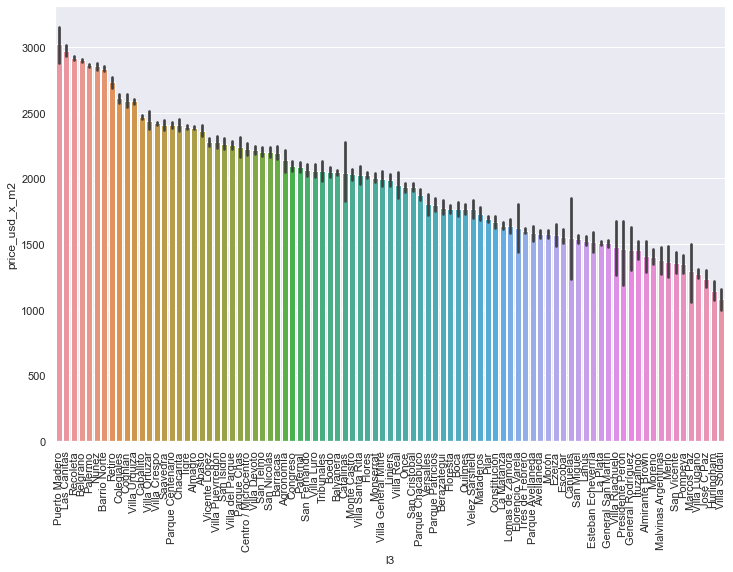

In [27]:
plt.xticks(rotation = 90)
barrios = df_filtered.groupby('l3').mean().sort_values('price_usd_x_m2', ascending=False).index
sns.barplot(x="l3", y="price_usd_x_m2", order=barrios, data=df_filtered);

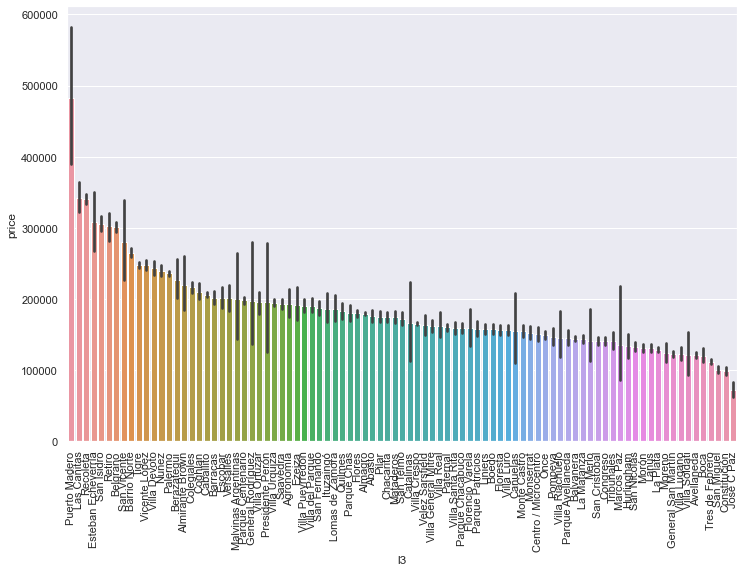

In [28]:
# Comparamos con la variable objetivo
plt.xticks(rotation = 90)
barrios = df_filtered.groupby('l3').mean().sort_values('price', ascending=False).index
sns.barplot(x="l3", y="price", order=barrios, data=df_filtered);

In [29]:
table = pd.pivot_table(df_filtered, values='price_usd_x_m2', index=['l3'], aggfunc=np.mean)
mas_caros = table.sort_values('price_usd_x_m2', ascending=False).iloc[:5]
mas_caros

,price_usd_x_m2
l3,
Puerto Madero,3023.936286
Las Cañitas,2972.832217
Recoleta,2917.542466
Belgrano,2898.515015
Palermo,2860.503488


In [30]:
table = pd.pivot_table(df_filtered, values='price_usd_x_m2', index=['l3'], aggfunc=np.mean)
mas_baratos = table.sort_values('price_usd_x_m2', ascending=True).iloc[:5]
mas_baratos

,price_usd_x_m2
l3,
Villa Soldati,1079.543988
Hurlingham,1144.625853
José C Paz,1234.392061
Villa Lugano,1273.522826
Marcos Paz,1292.321674


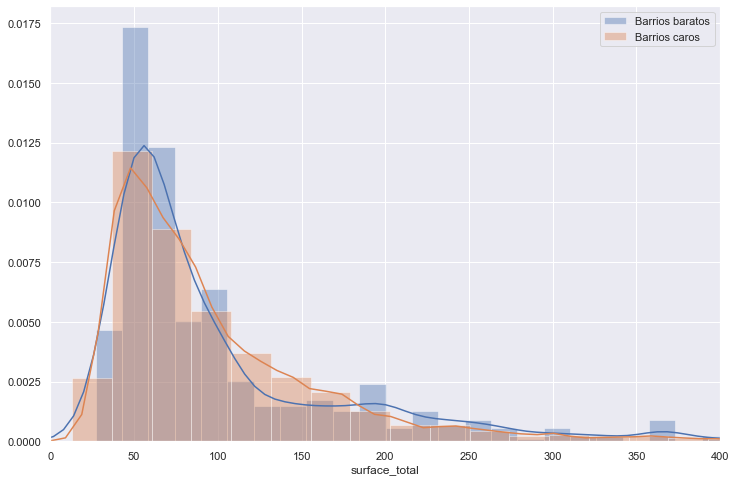

In [31]:
barrios_caros = mas_caros.index 
barrios_baratos = mas_baratos.index

# distribuciones según superficie total
g = sns.distplot(df_filtered[df_filtered.l3.isin(barrios_baratos)].surface_total, label="Barrios baratos")
sns.distplot(df_filtered[df_filtered.l3.isin(barrios_caros)].surface_total, label="Barrios caros")
g.set_xlim(0, 400)
plt.legend()

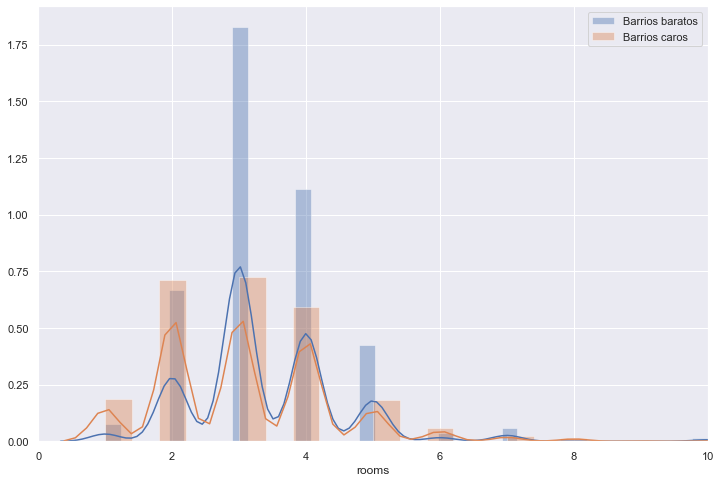

In [32]:
# distribuciones según Cuartos totales
g = sns.distplot(df_filtered[df_filtered.l3.isin(barrios_baratos)].rooms, label="Barrios baratos")
sns.distplot(df_filtered[df_filtered.l3.isin(barrios_caros)].rooms, label="Barrios caros")
g.set_xlim(0, 10)
plt.legend()

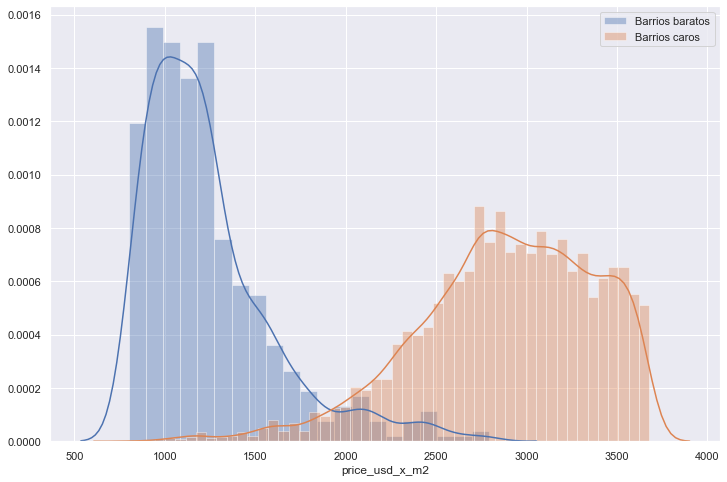

In [33]:
# distribuciones según precio por metro cuadrado 
g = sns.distplot(df_filtered[df_filtered.l3.isin(barrios_baratos)].price_usd_x_m2, label="Barrios baratos")
sns.distplot(df_filtered[df_filtered.l3.isin(barrios_caros)].price_usd_x_m2, label="Barrios caros")
plt.legend()

#### 4. Outliers

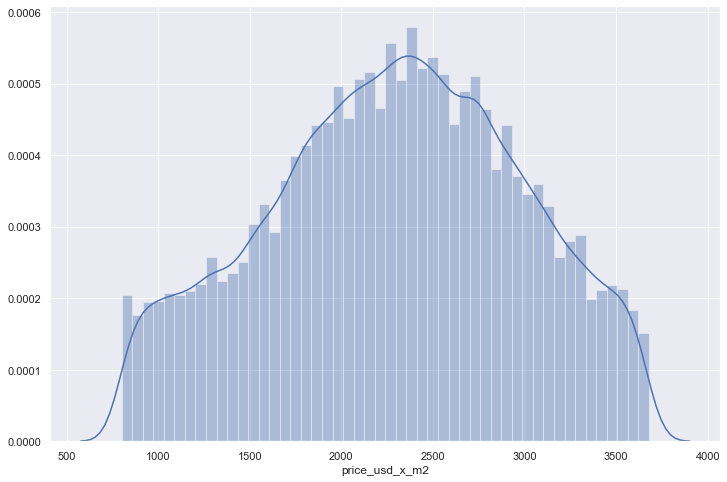

In [34]:
# Mostrar la figura 
df_filtered.dropna(subset=['price_usd_x_m2'], inplace=True)
df_filtered.price_usd_x_m2.isnull().value_counts()

ax = sns.distplot(df_filtered['price_usd_x_m2'])

<AxesSubplot:xlabel='price_usd_x_m2'>

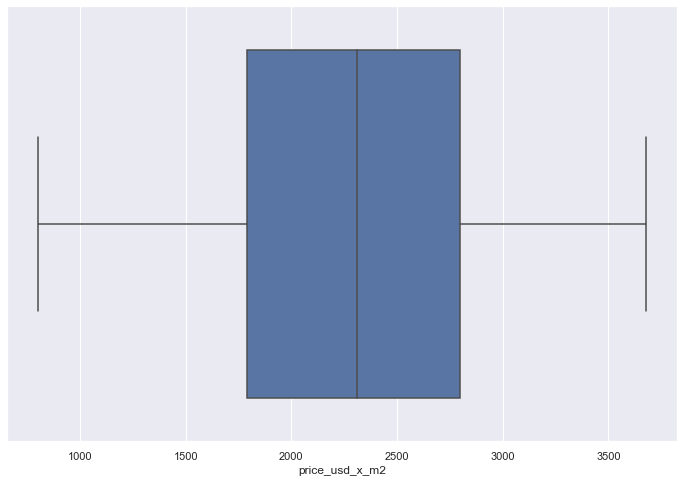

In [35]:
# boxplot de la columna price_usd_x_m2
sns.boxplot(x=df_filtered['price_usd_x_m2'])

In [36]:
# Describimos price_usd_x_m2 mostrando sus estadísticos
df_filtered.price_usd_x_m2.describe()

count    97455.000000
mean      2284.376843
std        696.766837
min        800.000000
25%       1790.000000
50%       2308.823529
75%       2800.000000
max       3679.245283
Name: price_usd_x_m2, dtype: float64

In [37]:
df_faltantes = df_filtered.isna()
df_num_faltantes = df_faltantes.sum()
print("Los porcentajes  de valores faltantes -expresados sobre uno- en cada categoría son:")
df_num_faltantes/len(df_filtered)

Los porcentajes  de valores faltantes -expresados sobre uno- en cada categoría son:


start_date         0.000000
end_date           0.000000
created_on         0.000000
lat                0.061526
lon                0.061526
l1                 0.000000
l2                 0.000000
l3                 0.000000
rooms              0.000000
bedrooms           0.000000
bathrooms          0.013647
surface_total      0.000000
surface_covered    0.000000
price              0.000000
currency           0.000000
title              0.000000
description        0.000000
property_type      0.000000
operation_type     0.000000
price_usd_x_m2     0.000000
dtype: float64

#### 5. Imputación de valores faltantes

In [38]:
# Imputar con la mediana en bathrooms
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median')
imp.fit(df_filtered[["bathrooms"]])

df_filtered["bathrooms"]=imp.transform(df_filtered[["bathrooms"]])
print(imp.transform(df_filtered[["bathrooms"]]))

[[2.]
 [2.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [39]:
df_faltantes = df_filtered.isna()
df_num_faltantes = df_faltantes.sum()
print("Los porcentajes  de valores faltantes -expresados sobre uno- en cada categoría son:")
df_num_faltantes/len(df_filtered)

Los porcentajes  de valores faltantes -expresados sobre uno- en cada categoría son:


start_date         0.000000
end_date           0.000000
created_on         0.000000
lat                0.061526
lon                0.061526
l1                 0.000000
l2                 0.000000
l3                 0.000000
rooms              0.000000
bedrooms           0.000000
bathrooms          0.000000
surface_total      0.000000
surface_covered    0.000000
price              0.000000
currency           0.000000
title              0.000000
description        0.000000
property_type      0.000000
operation_type     0.000000
price_usd_x_m2     0.000000
dtype: float64

#### 6. Variables binarias 

###### Convertimos las variables de property_type utilizando LabelEncoder

In [40]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df_filtered[["property_type"]])
df_filtered["property_type"] = le.transform(df_filtered[["property_type"]])

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [41]:
# Mostrar la propiedad classes_ del LabelEncoder
list(le.classes_)

['Casa', 'Departamento', 'PH']

In [42]:
# Utilizamos OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
X = onehot_encoder.fit_transform(df_filtered.property_type.values.reshape(-1,1))
categorical_df = pd.DataFrame(X, columns = ["Property_type_"+str(int(i)) for i in range(X.shape[1])])
categorical_df.head()

,Property_type_0,Property_type_1,Property_type_2
0,0.0,1.0,0.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [43]:
# Unimos el nuevo dataframe categorical_df con el dataframe original
categorical_df = categorical_df.set_index(df_filtered.index)
df_filtered = pd.concat([df_filtered, categorical_df], axis=1)
df_filtered.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type,price_usd_x_m2,Property_type_0,Property_type_1,Property_type_2
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****","DESCRIPCION DE LA PROPIEDAD: Departamento de 140,65 metros cubiertos según escritura. Segundo piso por escalera. Dormitorios siete /",1,Venta,1092.857143,0.0,1.0,0.0
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,"PH reciclado en Boedo a una cuadra de la plaza sin expensas, solo 4 propietarios en el edificio en muy buen estado.58 m2 cubiertos + 12 m2 de patioabajo: living comedor doble altura patio, toilette, cocina y lavaderoarriba: dormitorio con buen placard y baño completo.Impecable. Luz, sol y verde.Claudia Mascitti CMCPSI 6019",2,Venta,2271.428571,0.0,0.0,1.0
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Palermo,"2 ambienets amplio , excelente estado , patio , cocina comedor . 45 mts. Migliorisi VE - Se deja constancia que las caracteristicas, medidas, expensas y superficies consignadas son aproximadas, sujetos a verificación y/o ajuste. El precio del inmueble puede ser modificado sin previo aviso. Fotos de carácter no contractual. Las unidades publicadas están sujetas a disponibilidad.",2,Venta,2777.777778,0.0,0.0,1.0
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH 2 AMBIENTES,"HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE RECICLADOS!!!LIVING/COMEDOR AL CONTRAFRENTE CON SALIDA A PATIO CON ADOQUINES Y PALMERA-DORMITORIO CON BALCON-COCINA Y BAÑO-TERRAZA//SUPER LUMINOSO Y CON EXCELENTE VENTILACION!!!ESTA UBICADO EN PLANTA BAJA, ES EL DEPTO DEL MEDIO POR PASILLOEXCELENTE UBICACION, DONDE NO SE PERMITEN LA CONSTRUCCION DE EDIFICIOS, POR LO QUE SE GARANTIZA EL AIRE Y EL SOL.APTO PROFESIONALNO PAGA EXPENSAS!!!Sup.Total: 85 MtsSup.Cub: 50 MtsSup.desc: 35 MtsSe deja constancia que las medidas (tanto totales como parciales), superficies, m2 y proporciones indicadas en el presente son aproximadas y sujetas a verificación, variación y/o ajuste. Las expensas pueden sufrir variaciones.",2,Venta,3470.588235,0.0,0.0,1.0
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,"58 entre 1 y 2 Venta de departamento en ph.1 Dormitorio , La Plata","58 entre 1 y 2 Venta de departamento en PH. Primer piso por escaleras. Living comedor, cocina integrada, 1 dormitorio , baño con ducha, terraza de 15 metros, tipo de calefacción por tiro balanceado, ventilación cruzada, zona de facultades. SIN EXPENSAS",2,Venta,800.000000,0.0,0.0,1.0


In [44]:
#  Validamos tipo de datos de cada columna del Dataframe 
print("Los tipos de datos del dataset son:")
df_filtered.dtypes

Los tipos de datos del dataset son:


start_date          object
end_date            object
created_on          object
lat                float64
lon                float64
l1                  object
l2                  object
l3                  object
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
price              float64
currency            object
title               object
description         object
property_type        int32
operation_type      object
price_usd_x_m2     float64
Property_type_0    float64
Property_type_1    float64
Property_type_2    float64
dtype: object

In [45]:
# Creamos el nuevo Dataframe con los datos filtrados
dataML = pd.DataFrame(df_filtered.query('l2 in "Capital Federal"'))[['rooms', 'bedrooms', 'bathrooms','surface_total','surface_covered','price_usd_x_m2','Property_type_0','Property_type_1', 'Property_type_2', 'price']]

In [46]:
#  Validamos tipo de datos de cada columna del Dataframe 
print("Los tipos de datos del dataset son:")
dataML.dtypes

Los tipos de datos del dataset son:


rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
price_usd_x_m2     float64
Property_type_0    float64
Property_type_1    float64
Property_type_2    float64
price              float64
dtype: object

In [47]:
df_faltantes = dataML.isna()
df_num_faltantes = df_faltantes.sum()
print("Los porcentajes  de valores faltantes -expresados sobre uno- en cada categoría son:")
df_num_faltantes/len(dataML)

Los porcentajes  de valores faltantes -expresados sobre uno- en cada categoría son:


rooms              0.0
bedrooms           0.0
bathrooms          0.0
surface_total      0.0
surface_covered    0.0
price_usd_x_m2     0.0
Property_type_0    0.0
Property_type_1    0.0
Property_type_2    0.0
price              0.0
dtype: float64

In [48]:
# Descartar aquellas instacias con valores faltantes
dataML = dataML.dropna()

# Número de filas y columnas Data Frame con los datos filtrados
print("El dataset tiene {} filas".format(dataML.shape[0]))
print("El dataset tiene {} columnas".format(dataML.shape[1]))
dataML.head()

El dataset tiene 69123 filas
El dataset tiene 10 columnas


,rooms,bedrooms,bathrooms,surface_total,surface_covered,price_usd_x_m2,Property_type_0,Property_type_1,Property_type_2,price
0,7.0,7.0,2.0,140.0,140.0,1092.857143,0.0,1.0,0.0,153000.0
1,2.0,1.0,2.0,70.0,58.0,2271.428571,0.0,0.0,1.0,159000.0
2,2.0,1.0,1.0,45.0,45.0,2777.777778,0.0,0.0,1.0,125000.0
3,2.0,1.0,1.0,85.0,50.0,3470.588235,0.0,0.0,1.0,295000.0
5,2.0,1.0,1.0,56.0,56.0,2678.571429,0.0,0.0,1.0,150000.0


<AxesSubplot:>

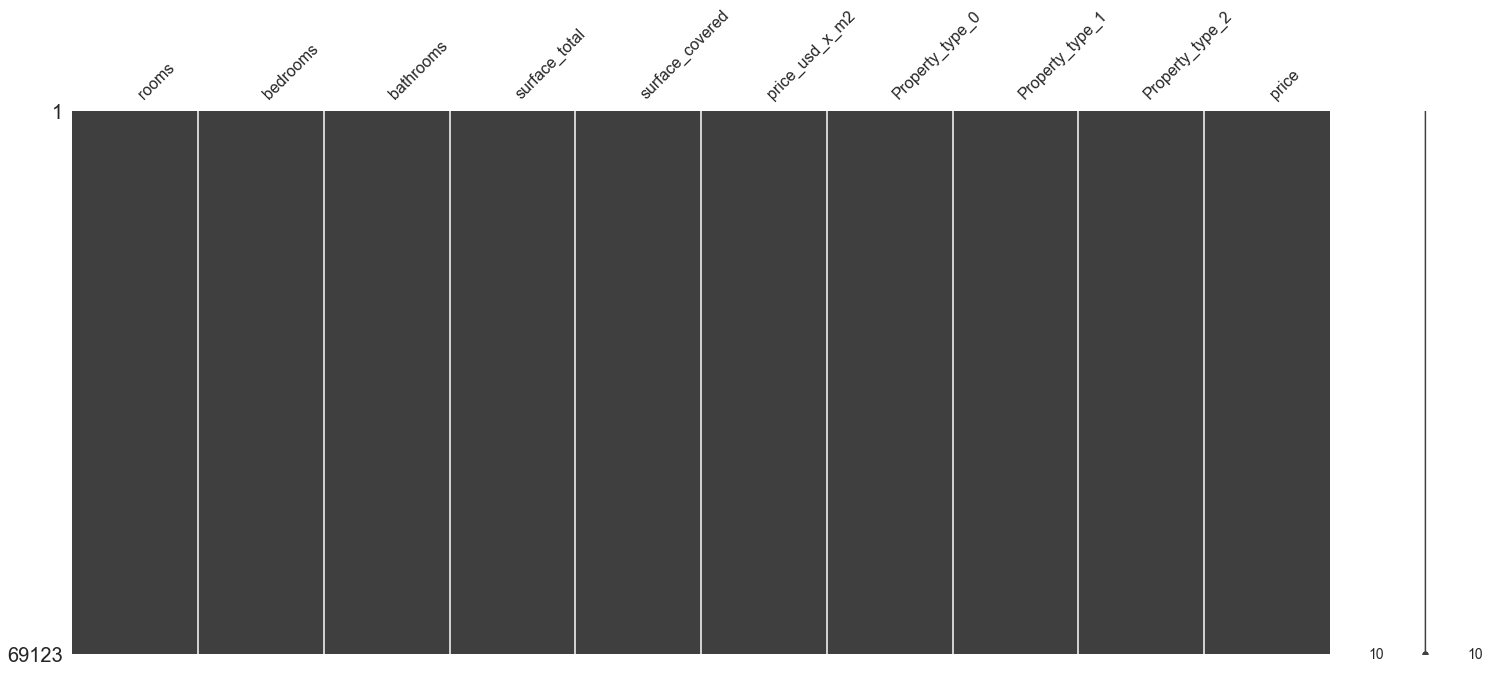

In [49]:
msno.matrix(dataML)

In [50]:
# Ordenamos y filtramos las correlaciones con el precio
dataML.corr()['price'].sort_values(ascending = False)

price              1.000000
surface_covered    0.846825
surface_total      0.829459
bathrooms          0.669209
rooms              0.661174
bedrooms           0.616615
Property_type_0    0.239287
price_usd_x_m2     0.165442
Property_type_2    0.026907
Property_type_1   -0.134226
Name: price, dtype: float64

## PARTE B - Modelos Avanzados

###### GridSearchCV nos permite testear a través de un espacio de búsqueda de parámetros la mejor combinación posible dado un estimador.

In [51]:
# Hacemos la separación 
X = dataML.drop(['price'], axis=1)
y = dataML['price']

import numpy as np
np.random.seed(123)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=2)

print(X_train.shape[0], X_test.shape[0])

48386 20737


In [52]:
print(f"X_train is {X_train.shape}")
print(f"X_test shape is {X_test.shape}")
# print(f"X_validate shape is {X_validate.shape}")
print(f"y_train shape is {y_train.shape}")
# print(f"y_validate shape is {y_validate.shape}")
print(f"y_test shape is {y_test.shape}")

X_train is (48386, 9)
X_test shape is (20737, 9)
y_train shape is (48386,)
y_test shape is (20737,)


In [53]:
from sklearn.metrics import mean_squared_error
def root_mean_squared_error(y_true, y_pred):
    ''' Root mean squared error regression loss
    
    Parameters
    ----------
    y_true : array-like of shape = (n_samples) or (n_samples, n_outputs)
    Ground truth (correct) target values.

    y_pred : array-like of shape = (n_samples) or (n_samples, n_outputs)
    Estimated target values.
    '''
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [54]:
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn import tree

In [55]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

In [56]:
pipe_tree = make_pipeline(tree.DecisionTreeRegressor(random_state=2))

In [57]:
# Creamos arreglo con las profundidades a evaluares
depths = np.arange(1, 21)
depths

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [58]:
num_leafs = [1, 5, 10, 20, 50, 100]

In [59]:
from sklearn.model_selection import GridSearchCV

In [60]:
param_grid = [{'decisiontreeregressor__max_depth':depths,
              'decisiontreeregressor__min_samples_leaf':num_leafs}]

In [61]:
gs = GridSearchCV(estimator=pipe_tree, param_grid=param_grid, scoring=rmse_scorer, cv=10)

In [62]:
gs = gs.fit(X_train, y_train)

In [63]:
print(-gs.best_score_)

13310.568746127796


In [64]:
print(gs.best_params_)

{'decisiontreeregressor__max_depth': 15, 'decisiontreeregressor__min_samples_leaf': 1}


In [65]:
my_model = gs.best_estimator_

In [66]:
my_model.fit(X_train, y_train)

Pipeline(steps=[('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=15, random_state=2))])

In [67]:
y_predicted = my_model.predict(X_test)
root_mean_squared_error(y_test, y_predicted)

16307.94085783753

## Entrenar el modelo implementado en la Entrega 01 - en particular, el árbol de decisión - y evalúa su desempeño a partir del dataset obtenido luego de transformar los datos

In [68]:
# Importamos librerías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split #importar módulo Skl
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor #importa la clase
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import tree

#### Ajuste de modelos y su posterior evaluación
##### Divideremos el dataset en un conjunto de entrenamiento (70%) y un conjunto de pruebas (test) (30%).

###### Separamos el dataset en `X_train`, `X_test`, `y_train` e `y_test` con el tamaño correspondiente

In [69]:
# Realizar un Train/Test split de los datos.
X = dataML.drop(['price'], axis=1) # quitar la columna target
y = dataML['price'] # columna target

X_train, X_test, y_train, y_test = train_test_split (X,y, test_size=0.3, random_state = 2) #separar conjuntos 

print("Train test size: ", X_train.shape)
print("Test train size: ", X_test.shape)
X.head()

Train test size:  (48386, 9)
Test train size:  (20737, 9)


,rooms,bedrooms,bathrooms,surface_total,surface_covered,price_usd_x_m2,Property_type_0,Property_type_1,Property_type_2
0,7.0,7.0,2.0,140.0,140.0,1092.857143,0.0,1.0,0.0
1,2.0,1.0,2.0,70.0,58.0,2271.428571,0.0,0.0,1.0
2,2.0,1.0,1.0,45.0,45.0,2777.777778,0.0,0.0,1.0
3,2.0,1.0,1.0,85.0,50.0,3470.588235,0.0,0.0,1.0
5,2.0,1.0,1.0,56.0,56.0,2678.571429,0.0,0.0,1.0


In [70]:
y.head()

0    153000.0
1    159000.0
2    125000.0
3    295000.0
5    150000.0
Name: price, dtype: float64

#### Árboles de decisión 
##### Entrenar un árbol de decisión y usar de métrica al RMSE.
Se obtiene el RMSE, vamos a medir el mean_squared_error y obtener su raíz cuadrada.

In [71]:
# Entrenar un modelo de árbol de decisión

# tree_reg = DecisionTreeRegressor(random_state = 2) 
tree_reg = DecisionTreeRegressor(max_depth = 15, random_state = 2) 
#asignar el DTRegressor a tree_reg. Es regressor porque es una variable continua (PRECIOS).
tree_reg.fit(X_train, y_train) #entrenar en los dos conjuntos


DecisionTreeRegressor(max_depth=15, random_state=2)

In [72]:
# Realizar la predicción
y_pred = tree_reg.predict(X_test)
print(y_pred)

[231333.33333333 169948.53571429  53000.         ... 145000.
 429000.         145000.        ]


In [73]:
# Calcular el RMSE
tree_mse = mean_squared_error(y_test, y_pred) #error cuadrático medio
tree_rmse = np.sqrt(tree_mse) #sacar la raíz cuadrada
print("RMSE: ", tree_rmse)

RMSE:  16307.94085783753


In [74]:
# Analizar el cambio en el RMSE a medida que es más profundo el árbol de decisión
# En training y testing.
rmses_train = []
rmses_test= []

profundidad = [5, 10, 15, 20, 25, 30]
for value in profundidad:
    # asignar las profundidades del árbol mediante el loop
    deep_reg_tree = DecisionTreeRegressor(max_depth=value, random_state = 2)
    
    # entrenar el modelo   
    deep_reg_tree.fit(X_train, y_train) 
    
    # predecir sobre X_test, sacando el MSE y RMSE sobre y_test e y_pred_test
    y_pred_test = deep_reg_tree.predict(X_test) 
    tree_mse_test = mean_squared_error(y_test, y_pred_test)
    tree_rmse_test = np.sqrt(tree_mse_test)
    
    # predecir sobre X_train, sacando el MSE y RMSE sobre y_test e y_pred_test
    y_pred_train = deep_reg_tree.predict(X_train)
    tree_mse_train = mean_squared_error(y_train, y_pred_train)
    tree_rmse_train = np.sqrt(tree_mse_train)
    
    rmses_train.append(tree_rmse_train) #agregar la información a las listas de arriba
    rmses_test.append(tree_rmse_test) #agregar la información a las listas de arriba

In [75]:
print(rmses_train)
print(rmses_test)

[42832.37478506131, 6520.26701801057, 456.61222578557505, 8.34319507582962, 0.0, 0.0]
[47785.76615941252, 17739.806254169456, 16307.94085783753, 16125.1055402133, 16337.229590633266, 16337.229590633266]


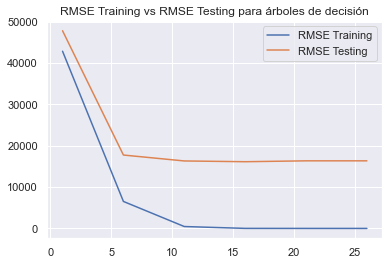

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(range(1,30, 5), rmses_train, label='RMSE Training')
plt.plot(range(1,30, 5), rmses_test, label='RMSE Testing')
plt.title("RMSE Training vs RMSE Testing para árboles de decisión")
plt.legend(loc="best")
plt.show()

*El modelo presenta sobreajuste dado que a mayor complejidad (en este caso, mayor profundidad del árbol) más diferencia entre los resultados de `training` y `testing`. También observamos como la curva de testing decrece y luego vuelvo a crecer.*

##### En una variable llamada regressor guardamos el árbol de decisión.

In [77]:
regressor = DecisionTreeRegressor(max_depth=15) #árbol con profundidad 16
model = regressor.fit(X_train, y_train) #entrenamiento
y_predict = model.predict(X_test) #predicción
mse = mean_squared_error(y_test, y_predict)
print('Root Mean Squared Error: ', format(np.sqrt(mse)))

Root Mean Squared Error:  16676.23155352361


In [78]:
def nmsq2rmse(score):
    return np.sqrt(-score)

In [79]:
# Calcular los cross_val_score

scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
rmse_scores = []
for score in scores:
    rmse = nmsq2rmse(score)
    rmse_scores.append(rmse)
    print('Root Mean Squared Error: ', rmse)

Root Mean Squared Error:  47293.502995179886
Root Mean Squared Error:  8173.354446896769
Root Mean Squared Error:  6888.737288157973
Root Mean Squared Error:  20356.077568213223
Root Mean Squared Error:  7021.545043185444
Root Mean Squared Error:  11341.516638133166
Root Mean Squared Error:  8292.942349603309
Root Mean Squared Error:  9999.397076474645
Root Mean Squared Error:  5730.142687122174
Root Mean Squared Error:  7253.876575666532


##### Reentrenamos al regresor y mostramos en un dataframe la comparación entre los valores reales, las predicciones y la diferencia entre ellos

In [80]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
val_real = pd.Series(y_test.values)
val_pred = pd.Series(y_pred)

In [81]:
# Datos para el gráfico
preddf = pd.concat([val_real.rename('real'), val_pred.rename('pred')] ,  axis=1) # para el gráfico
# Datos para la tabla de diferencia
predicciones = pd.concat([val_real.rename('Valor Real'),val_pred.rename('Valor Pred') ,abs(val_real-val_pred).rename('Diferencia(+/-)')] ,  axis=1) # para mostrar en pantalla

In [82]:
predicciones.head(10)

,Valor Real,Valor Pred,Diferencia(+/-)
0,230000.0,2.313333e+05,1333.333333
1,170000.0,1.699485e+05,51.464286
2,52000.0,5.300000e+04,1000.000000
3,420000.0,4.200000e+05,0.000000
4,1700000.0,1.700000e+06,0.000000
5,125000.0,1.250000e+05,0.000000
6,180000.0,1.800000e+05,0.000000
7,430000.0,4.416667e+05,11666.666667
8,159000.0,1.589800e+05,20.000000
9,139375.0,1.393750e+05,0.000000


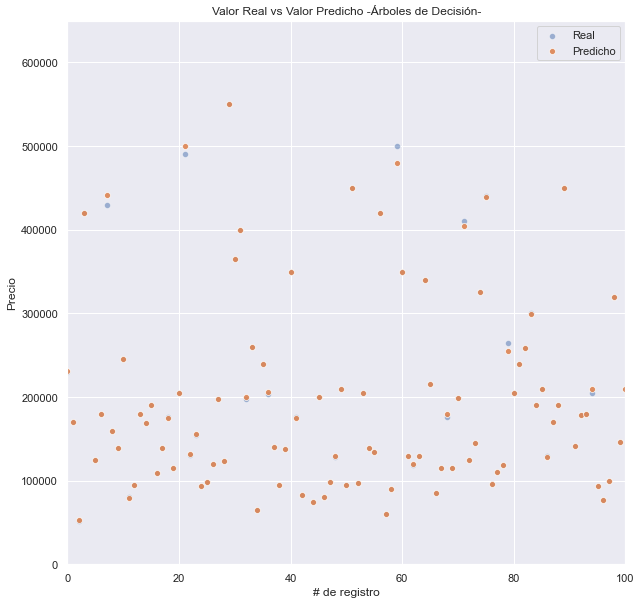

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(figsize = (10,10))
# plt.figure()

plt.xlim((0, 100)) # Mostramos los primeros n registros
plt.ylim((0, 650000)) # Limitamos la escala para mejorar visualización

sns.scatterplot(x = range(0, len(preddf), 1), y = "real", data = preddf, label = "Real", alpha = 0.5)
sns.scatterplot(x = range(0, len(preddf), 1), y = "pred", data = preddf, label = "Predicho", alpha = 0.9)

plt.title("Valor Real vs Valor Predicho -Árboles de Decisión-")
plt.ylabel('Precio')
plt.xlabel('# de registro')
plt.show()

##### Nótese que en el resultado de las predicciones ya en este punto no existen diferencias y/o para algunos solo diferencias mínimas en el precio, y es posible que obedezcan como excepción a propiedades sobreestimadas o subvaloradas como habitualmente se encuentran en el mercado inmobiliario.

##### El desempeño obtenido en comparación al inicial ha mejorado lo cuál obedece a la transformación de datos realizada sobre el dataset.

In [84]:
from sklearn.tree import DecisionTreeRegressor

tree_regressor = DecisionTreeRegressor(max_depth=15, random_state=2)


In [85]:
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=15, random_state=2)

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 456.61222578557505
Raíz del error cuadrático medio en Test: 16307.94085783753


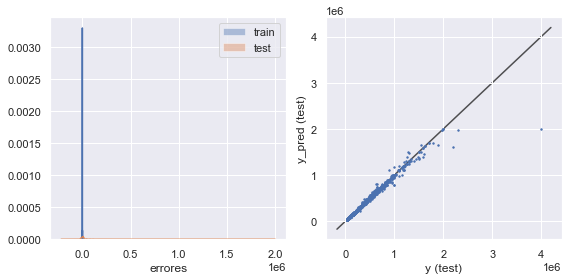

In [86]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
modelos = ['Árbol de Decisión']

for i, model in enumerate([tree_regressor]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    print(f'Modelo: {modelos[i]}')

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()


    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

### Importancia de cada Feature 

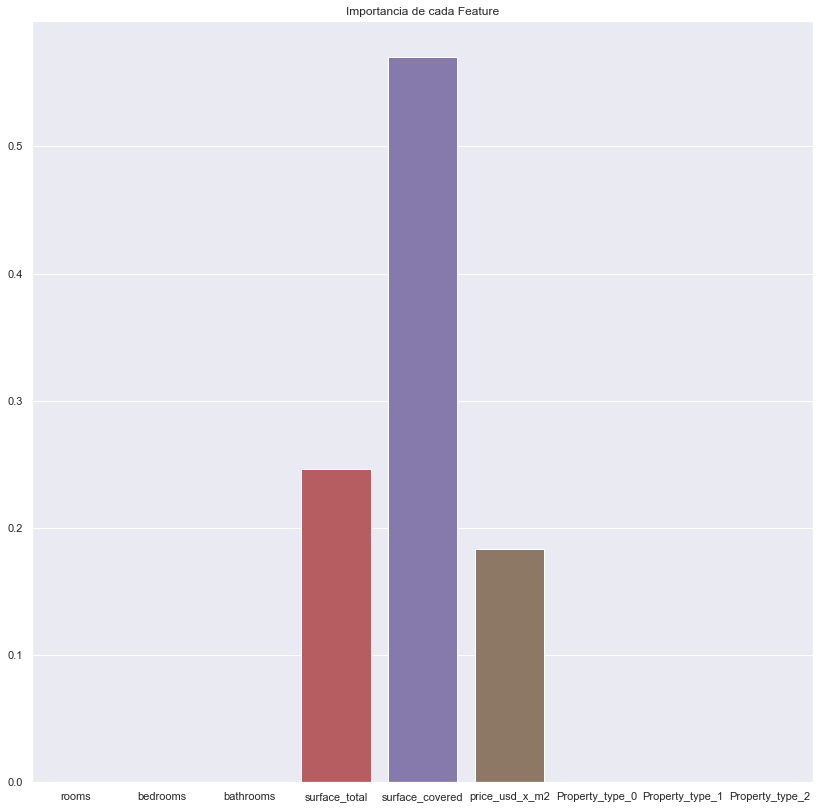

In [87]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth=15, random_state = 2) # importante cambio para regresión
clf.fit(X, y)
y_pred = clf.predict(X)
importances = clf.feature_importances_
columns = X.columns
plt.figure(figsize = (14,14))
# plt.figure()
sns.barplot(columns, importances)
plt.title('Importancia de cada Feature')
plt.show()

### Regresión lineal con atributos polinómicos

In [88]:
# Realizar un Train/Test split de los datos.
X_p = dataML.drop(['price'], axis=1) # quitar la columna target
y_p = dataML['price'] # columna target

from sklearn.model_selection import train_test_split

#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=0.3, random_state = 2)

print("Train test size: ", X_train_p.shape)
print("Test train size: ", X_test_p.shape)
X_p.head()


Train test size:  (48386, 9)
Test train size:  (20737, 9)


,rooms,bedrooms,bathrooms,surface_total,surface_covered,price_usd_x_m2,Property_type_0,Property_type_1,Property_type_2
0,7.0,7.0,2.0,140.0,140.0,1092.857143,0.0,1.0,0.0
1,2.0,1.0,2.0,70.0,58.0,2271.428571,0.0,0.0,1.0
2,2.0,1.0,1.0,45.0,45.0,2777.777778,0.0,0.0,1.0
3,2.0,1.0,1.0,85.0,50.0,3470.588235,0.0,0.0,1.0
5,2.0,1.0,1.0,56.0,56.0,2678.571429,0.0,0.0,1.0


In [89]:
from sklearn.preprocessing import PolynomialFeatures
#Se define el grado del polinomio
poli_reg = PolynomialFeatures(degree = 2)

# Se transforma las características existentes en características de mayor grado
X_train_poli = poli_reg.fit_transform(X_train_p)
X_test_poli = poli_reg.fit_transform(X_test_p)

In [90]:
#Defino el algoritmo a utilizar
pr = LinearRegression()

In [91]:
#Entreno el modelo
pr.fit(X_train_poli, y_train_p)

LinearRegression()

In [92]:
#Realizo una predicción
Y_pred_pr = pr.predict(X_test_poli)

In [93]:
print('Valor de la pendiente o coeficiente "a":')
print(pr.coef_)

Valor de la pendiente o coeficiente "a":
[-6.48425867e-18 -2.83435247e-10  2.67386446e-10 -1.83518756e-10
  4.73637796e-12 -1.68548508e-12  2.17936780e-13 -1.40933255e-11
  2.74394613e-12  1.13493546e-11 -7.13517136e-13 -1.80662495e-12
  5.71966563e-12  2.24662736e-13 -1.19739396e-13  1.39927674e-14
 -1.00745308e-10 -9.35028039e-11 -8.91896193e-11  9.23417267e-13
 -4.64966350e-12 -8.86101088e-14  7.94828613e-14  1.21079362e-14
  9.49757339e-11  9.43617943e-11  7.80540442e-11 -2.58693763e-12
  2.64633150e-13 -1.90055816e-13  4.46313993e-14 -5.66670879e-11
 -6.33595762e-11 -6.34903357e-11 -7.01587226e-16  3.50414142e-16
  1.00000000e+00  1.50389406e-12  1.58454803e-12  1.64911682e-12
  2.18575158e-16  1.51143204e-15 -4.98090664e-13 -6.08368363e-13
 -5.80467423e-13  8.40674271e-16  7.63620937e-14  7.36494199e-14
  6.71546152e-14 -1.40932985e-11  0.00000000e+00  0.00000000e+00
  2.74394635e-12  0.00000000e+00  1.13493521e-11]


In [94]:
print('Valor de la intersección o coeficiente "b":')
print(pr.intercept_)

Valor de la intersección o coeficiente "b":
-5.966285243630409e-09


In [95]:
print('Precisión del modelo:')
print(pr.score(X_train_poli, y_train_p))

Precisión del modelo:
1.0


Modelo: Regresión lineal polinómica
Raíz del error cuadrático medio en Train: 2.7131704176411525e-09
Raíz del error cuadrático medio en Test: 2.7390567258403378e-09


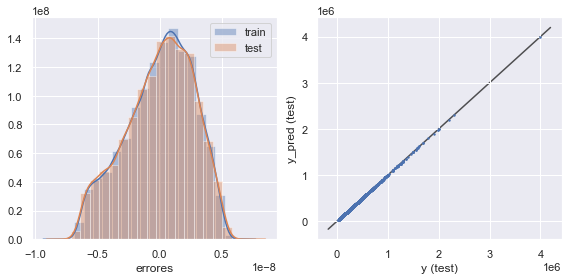

In [96]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
modelos = ['Regresión lineal polinómica']

for i, model in enumerate([pr]):
    y_train_pred = model.predict(X_train_poli)
    y_test_pred = model.predict(X_test_poli)
    
    
    print(f'Modelo: {modelos[i]}')

    rmse_train = np.sqrt(mean_squared_error(y_train_p, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test_p, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train_p - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test_p - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()


    ax = plt.subplot(1,2,2)
    ax.scatter(y_test_p,y_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

In [164]:
pr.fit(X_train_poli, y_train_p)
y_pred = pr.predict(X_test_poli)
val_real = pd.Series(y_test_p.values)
val_pred = pd.Series(y_pred)

In [165]:
preddf = pd.concat([val_real.rename('real'), val_pred.rename('pred')] ,  axis=1)
predicciones = pd.concat([val_real.rename('Valor Real'),val_pred.rename('Valor Pred') ,abs(val_real-val_pred).rename('Diferencia(+/-)')] ,  axis=1)

In [166]:
predicciones.head(10)

,Valor Real,Valor Pred,Diferencia(+/-)
0,230000.00,230000.00,0.00
1,170000.00,170000.00,0.00
2,52000.00,52000.00,0.00
3,420000.00,420000.00,0.00
4,1700000.00,1700000.00,0.00
5,125000.00,125000.00,0.00
6,180000.00,180000.00,0.00
7,430000.00,430000.00,0.00
8,159000.00,159000.00,0.00
9,139375.00,139375.00,0.00


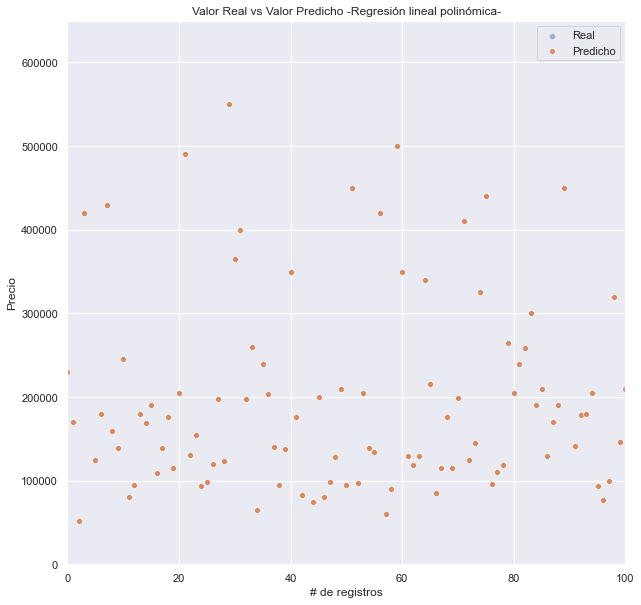

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(figsize = (10,10))

plt.xlim((0, 100)) # Mostramos los primeros n registros
plt.ylim((0, 650000)) # Limitamos la escala para mejorar visualización


sns.scatterplot(x = range(0, len(preddf), 1), y = "real", data = preddf, label = "Real", alpha = 0.5)
sns.scatterplot(x = range(0, len(preddf), 1), y = "pred", data = preddf, label = "Predicho", alpha = 0.9)

plt.title("Valor Real vs Valor Predicho -Regresión lineal polinómica-")
plt.ylabel('Precio')
plt.xlabel('# de registros')
plt.show()

### Regresión lineal con regularización

In [101]:
# Realizar un Train/Test split de los datos.
X = dataML.drop(['price'], axis=1) # quitar la columna target
y = dataML['price'] # columna target

X_train, X_test, y_train, y_test = train_test_split (X,y, test_size=0.3, random_state = 2) #separar conjuntos 

print("Train test size: ", X_train.shape)
print("Test train size: ", X_test.shape)
X.head()

Train test size:  (48386, 9)
Test train size:  (20737, 9)


,rooms,bedrooms,bathrooms,surface_total,surface_covered,price_usd_x_m2,Property_type_0,Property_type_1,Property_type_2
0,7.0,7.0,2.0,140.0,140.0,1092.857143,0.0,1.0,0.0
1,2.0,1.0,2.0,70.0,58.0,2271.428571,0.0,0.0,1.0
2,2.0,1.0,1.0,45.0,45.0,2777.777778,0.0,0.0,1.0
3,2.0,1.0,1.0,85.0,50.0,3470.588235,0.0,0.0,1.0
5,2.0,1.0,1.0,56.0,56.0,2678.571429,0.0,0.0,1.0


In [102]:
# Seleccionar el mejor alpha con LassoCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
lassoregcv = LassoCV(n_alphas=100, normalize=True, random_state=2)
lassoregcv.fit(X_train, y_train)
print('alpha : ',lassoregcv.alpha_)


alpha :  0.5782073587689124


In [103]:
lassoreg = Lasso(alpha=lassoregcv.alpha_, normalize=True)
lassoreg.fit(X_train, y_train)
print(lassoreg.coef_)

[ 11753.94457677  -8543.11696677  13906.3799359    1380.37300114
    725.47074867     93.41186317 -54805.80350176  12156.60857912
     -0.        ]


In [104]:
# predict method uses the best alpha value
y_pred = lassoregcv.predict(X_test)
# calculamos RMSE

from sklearn import metrics

# print("R-Square Value", r2_score(y_test,y_pred))
print ("root_mean_squared_error : ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

root_mean_squared_error :  51321.61996452555


Modelo: Regresión lineal con regularización
Raíz del error cuadrático medio en Train: 49815.29684790248
Raíz del error cuadrático medio en Test: 51321.61996452555


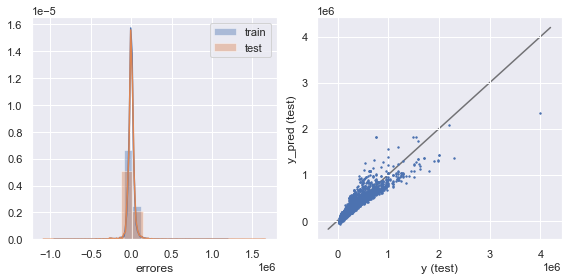

In [105]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
modelos = ['Regresión lineal con regularización']

for i, model in enumerate([lassoreg]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    print(f'Modelo: {modelos[i]}')

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()


    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=lassoregcv.alpha_, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

In [106]:
lassoregcv.fit(X_train, y_train)
y_pred2 = lassoreg.predict(X_test)
val_real2 = pd.Series(y_test.values)
val_pred2 = pd.Series(y_pred2)

In [107]:
preddf = pd.concat([val_real2.rename('real'), val_pred2.rename('pred')] ,  axis=1)
predicciones2 = pd.concat([val_real2.rename('Valor Real'),val_pred2.rename('Valor Pred') ,abs(val_real2-val_pred2).rename('Diferencia(+/-)')] ,  axis=1)

In [108]:
predicciones2.head(10)

,Valor Real,Valor Pred,Diferencia(+/-)
0,230000.0,2.377538e+05,7753.756187
1,170000.0,1.670429e+05,2957.055961
2,52000.0,8.891659e+04,36916.586028
3,420000.0,4.144851e+05,5514.863659
4,1700000.0,1.363786e+06,336214.497692
5,125000.0,1.185028e+05,6497.247750
6,180000.0,1.837307e+05,3730.673469
7,430000.0,3.404940e+05,89506.023715
8,159000.0,1.879650e+05,28964.985366
9,139375.0,1.744801e+05,35105.103132


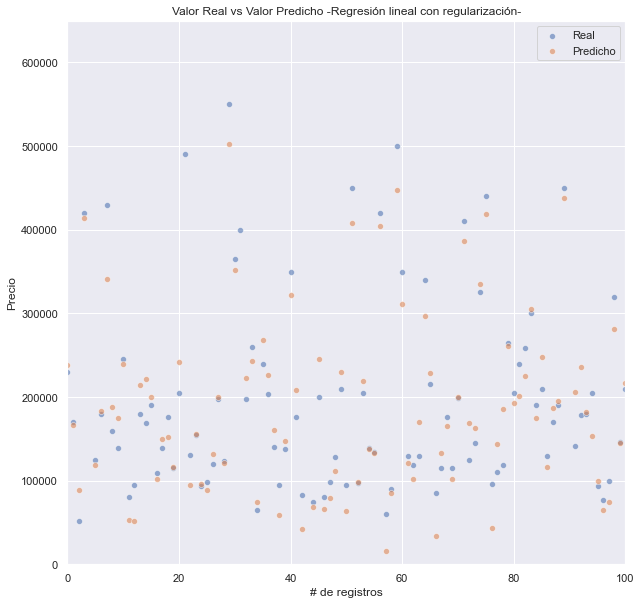

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(figsize = (10,10))

plt.xlim((0, 100)) # Mostramos los primeros n registros
plt.ylim((0, 650000)) # Limitamos la escala para mejorar visualización


sns.scatterplot(x = range(0, len(preddf), 1), y = "real", data = preddf, label = "Real", alpha = lassoregcv.alpha_)
sns.scatterplot(x = range(0, len(preddf), 1), y = "pred", data = preddf, label = "Predicho", alpha = lassoregcv.alpha_)

plt.title("Valor Real vs Valor Predicho -Regresión lineal con regularización-")
plt.ylabel('Precio')
plt.xlabel('# de registros')
plt.show()

## PARTE C - Interpretación de modelos

* ¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no?

###### Las variables relevantes para realizar las predicciones en el modelo fueron `surface_total`, `surface_covered`, y una de optimización agregada al dataset `price_usd_x_m2`.

###### Es probable que algunas variables sean minimizadas a simple vista en establecer la predicción en uno u otro modelo pero son de gran importancia en la clasificación, por ejemplo el tipo de propiedad. por lo tanto podríamos concluir que el dataset final optimizado como "un todo" es lo que permite integralmente realizar las prediciones con un alto grado de certeza.

###### Para los modelos entrenados (`árboles de decisión optimizado, regresión lineal con atributos polinómicos y regresión lineal con regularización`), teniendo en cuenta las instancias y columnas filtradas para la predicción del precio en regresión; seleccionaría el modelo de regresión lineal con atributos polinómicos ya que tanto los resultados de los valores de RMSE son menores y la diferencia en los valores del precio predicho con el precio real en las instancias son en su mayoría precisos en comparación con los del árbol de decisión tal cuál como lo muestran las tablas y gráficos comparativos.

##### Se evidencia la importancia de realizar las optimizaciones y depuraciones sobre el dataset en momentos específicos para garantizar la integridad de los datos, por ejemplo la eliminación registros duplicados debe realizarse cuando no se hayan filtrado features para asegurarse que realmente se vean afectados los duplicados y lograr registros únicos.

* ¿Dónde es mayor el error? ¿dónde acierta?

###### Teniendo en cuenta que la "varianza alta" es proporcional al overfitting y la "bias alta" es proporcional al underfitting, se prefieren los modelos con baja varianza y baja bias pero esto constituye un reto, podemos escoger modelos simples en su bias o su varianza; los modelos de regresión lineal y regresión logística por lo general tienen bias baja pero alta varianza.

##### Bias alta o varianza alta no siempre es malo pero pueden conducir a resultados pobres.

##### Bias y varianza tienen un papel importante en la decisión de cuál modelo usar.

##### Para los cálculos realizados y las operaciones llevadas a cabo continuación seleccionaríamos el modelo Decisión Tree Regressor por tener Bias y varianza menor.

##### Y entre los modelos líneales  de regresión seleccionaríamos el de atributos polinómicos que tiene mejores valores para loss="MSE" que el de regularización, lo cuál ratifica también el modelo de benchmarking llevado a cabo previamente.

###### Ver a continuación cálculo de los distintos tipos de errores:

In [110]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import random; random.seed(1982)

# graficos incrustados
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})

In [111]:
# Realizar un Train/Test split de los datos.
X = dataML.drop(['price'], axis=1) # quitar la columna target
y = dataML['price'] # columna target

x_train, x_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=2)

In [112]:
arbol = DecisionTreeClassifier(criterion='entropy')

In [113]:
arbol.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [114]:
print("Precisión entrenamiento: {0: .2f}".format(arbol.score(x_train, y_train)))

Precisión entrenamiento:  1.00


In [115]:
print("Precisión evaluación: {0: .2f}".format(arbol.score(x_eval, y_eval)))

Precisión evaluación:  0.78


In [116]:
arbol.tree_.max_depth

20

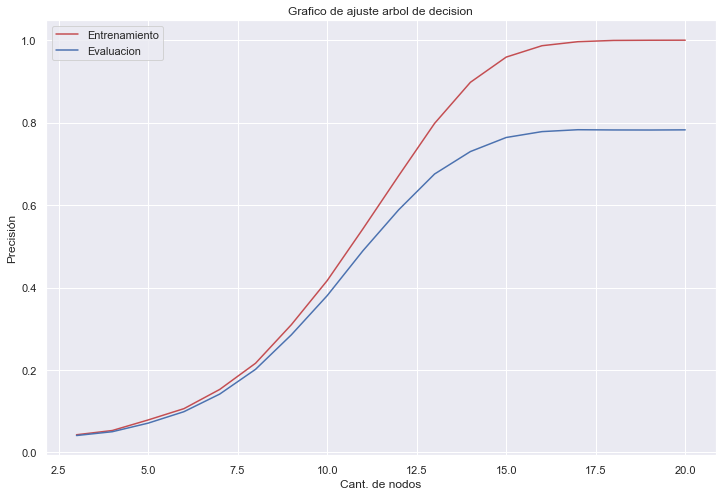

In [117]:
train_prec =  []
eval_prec = []
max_deep_list = list(range(3, 21))

for deep in max_deep_list:
    arbol3 = DecisionTreeClassifier(criterion='entropy', max_depth=deep)
    arbol3.fit(x_train, y_train)
    train_prec.append(arbol3.score(x_train, y_train))
    eval_prec.append(arbol3.score(x_eval, y_eval))
    
plt.figure(figsize=(12,8))
plt.plot(max_deep_list, train_prec, color='r', label='Entrenamiento')
plt.plot(max_deep_list, eval_prec, color='b', label='Evaluacion')
plt.title('Grafico de ajuste arbol de decision')
plt.legend()
plt.ylabel('Precisión')
plt.xlabel('Cant. de nodos')
plt.show()

In [118]:
from sklearn.model_selection import validation_curve

train_prec, eval_prec = validation_curve(estimator=arbol, X=x_train, y=y_train, param_name='max_depth', param_range=max_deep_list, cv=5)
#validacion cruzada: arbol de decision, define x, define y, parametro elegido, rango del paramentro, cantidad de folders
train_mean = np.mean(train_prec, axis=1) #media train
train_std = np.std(train_prec, axis=1) #desviacion estandar
test_mean = np.mean(eval_prec, axis=1) #media test
test_std = np.std(eval_prec, axis=1) #desviacion estandar

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


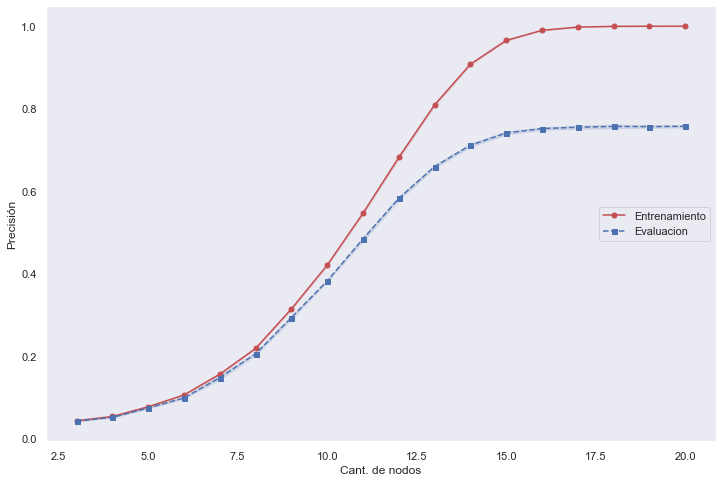

In [119]:
# graficando las curvas
plt.figure(figsize=(12,8))
plt.plot(max_deep_list, train_mean, color='r', marker='o', markersize=5, label='Entrenamiento')
plt.fill_between(max_deep_list, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
plt.plot(max_deep_list, test_mean, color='b', linestyle='--', marker='s', markersize=5, label='Evaluacion')
plt.fill_between(max_deep_list, test_mean + test_std, test_mean - test_std, alpha=0.15, color='b')
plt.grid()
plt.legend(loc='center right')
plt.xlabel('Cant. de nodos')
plt.ylabel('Precisión')
plt.show()

In [120]:
# Definimos un nuevo árbol con la profundidad calculada en los ajustes

# Realizar un Train/Test split de los datos.
X = dataML.drop(['price'], axis=1) # quitar la columna target
y = dataML['price'] # columna target

x_train, x_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=2)

arbol2 = DecisionTreeClassifier(criterion='entropy', max_depth=15)

In [121]:
arbol2.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15)

In [122]:
print("Precisión entrenamiento: {0: .2f}".format(arbol2.score(x_train, y_train)))

Precisión entrenamiento:  0.96


In [123]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=arbol2, X=x_train, y=y_train, train_sizes=np.linspace(0.1, 1, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


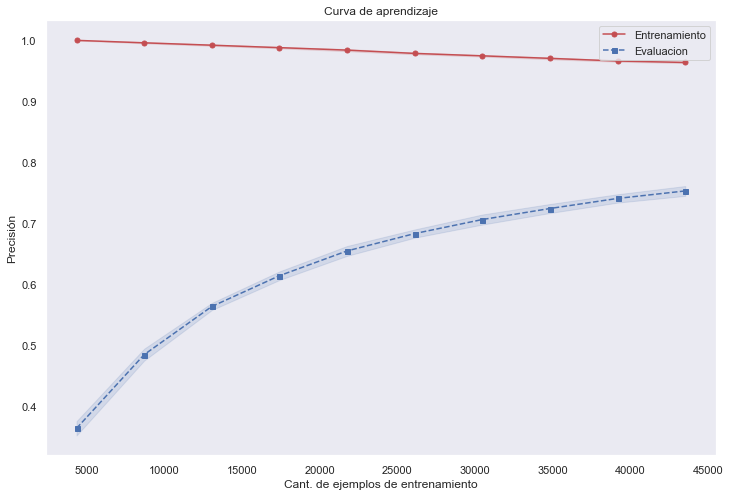

In [124]:
# graficando las curvas
plt.figure(figsize=(12,8))
plt.plot(train_sizes, train_mean, color='r', marker='o', markersize=5, label='Entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
plt.plot(train_sizes, test_mean, color='b', linestyle='--', marker='s', markersize=5, label='Evaluacion')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='b')
plt.grid()
plt.title('Curva de aprendizaje')
plt.legend(loc='upper right')
plt.xlabel('Cant. de ejemplos de entrenamiento')
plt.ylabel('Precisión')
plt.show()

In [125]:
!pip install mlxtend

##### Bias Variance Decomposition of a Decision Tree Regressor

In [126]:
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import bias_variance_decomp

# Cargar  dataset
X = dataML.drop(['price'], axis=1) # quitar la columna target
y = dataML['price'] # columna target

X = X.values
y = y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

model = DecisionTreeClassifier(random_state=2, max_depth=15)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        model, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)


Average expected loss: 0.443
Average bias: 0.301
Average variance: 0.363


##### Bias-variance decomposition of a bagging regressor

In [127]:
# Comparación con bagging regressor
from sklearn.ensemble import BaggingRegressor

# Cargar  dataset
X = dataML.drop(['price'], axis=1) # quitar la columna target
y = dataML['price'] # columna target

X = X.values
y = y.values

tree = DecisionTreeRegressor(random_state=2, max_depth=15)
bag = BaggingRegressor(base_estimator=tree,
                       n_estimators=100,
                       random_state=2)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        bag, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.969
Average bias: 0.873
Average variance: 0.953


#### Bias Variance Decomposition of a Decision Tree Classifier

In [128]:
from mlxtend.evaluate import bias_variance_decomp

# Cargar  dataset
X = dataML.drop(['price'], axis=1) # quitar la columna target
y = dataML['price'] # columna target

X = X.values
y = y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

model = DecisionTreeClassifier(random_state=2, max_depth=15)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        model, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)


Average expected loss: 0.443
Average bias: 0.301
Average variance: 0.363


#### Bias-variance MSE linear regressor (los modelos calculados con atributos polinómicos y con regularización)

In [129]:
from mlxtend.evaluate import bias_variance_decomp

# Cargar  dataset
X = dataML.drop(['price'], axis=1) # quitar la columna target
y = dataML['price'] # columna target

X = X.values
y = y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

model = pr

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        model, X_train, y_train, X_test, y_test, 
        loss='mse',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 2637346187.283
Average bias: 2632395001.248
Average variance: 4951186.035


In [129]:
from mlxtend.evaluate import bias_variance_decomp

# Cargar  dataset
X = dataML.drop(['price'], axis=1) # quitar la columna target
y = dataML['price'] # columna target

X = X.values
y = y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

model = lassoreg

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        model, X_train, y_train, X_test, y_test, 
        loss='mse',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 2638852516.415
Average bias: 2633901689.125
Average variance: 4950827.290


* ¿Qué mejorarías? Ten en cuenta siempre terminar con una discusión sobre lo realizado y conclusiones obtenidas.

##### La aplicación de modelos más complejos sobre este dataset en particular requieren una gran capacidad de cómputo que muchas veces no están disponibles de forma abierta en las diferentes plataformas.

##### El rendimiento de un modelo de aprendizaje automático se puede caracterizar en términos del sesgo y la varianza del modelo.

##### Un modelo con un alto sesgo hace suposiciones sólidas sobre la forma de la función subyacente desconocida que asigna entradas a salidas en el conjunto de datos, como la regresión lineal. Un modelo con una alta varianza depende en gran medida de las características específicas del conjunto de datos de entrenamiento, como los árboles de decisión sin podar. Deseamos modelos con bajo sesgo y baja varianza, aunque a menudo existe una compensación entre estas dos.

* Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?

#### Sí, coincide con lo esperaba después de realizar las optimizaciones.  Es de gran relevancia que el el dataset esté optimizado con las técnicas llevadas a cabo para realizar las predicciones más exactas. Así mismo se reitera que la información relacionada a la georeferenciación debe ser más precisa y mejorada al momento de su registro y/o digitación.

# Implementación de nuevos modelos de Machine Learning

### XGBoostRegressor

In [132]:
# Realizar un Train/Test split de los datos.
X = dataML.drop(['price'], axis=1) # quitar la columna target
y = dataML['price'] # columna target

X_train, X_test, y_train, y_test = train_test_split (X,y, test_size=0.3, random_state = 2) #separar conjuntos 

In [133]:
# Establecer parámetros
parameters = {'nthread': [4],
              'max_depth': np.arange(13, 16),
              'n_estimators': np.arange(215, 219)
              }

In [134]:
# Creación del modelo
gridsearch_xgboost = GridSearchCV(XGBRegressor(booster='gbtree',
                                             learning_rate=.02,
                                             importance_type='total_cover',
                                             colsample_bytree=0.62,
                                             random_state=2,
                                             n_jobs=-1),
                                param_grid=parameters, n_jobs=-1)

In [135]:
# Entrenamiento del modelo
gridsearch_xgboost.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=0.62, gamma=None,
                                    gpu_id=None, importance_type='total_cover',
                                    interaction_constraints=None,
                                    learning_rate=0.02, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=-1,
                                    num_parallel_tree=None, random_state=2,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,


In [136]:
# Mejores parámetros
gridsearch_xgboost.best_params_

{'max_depth': 13, 'n_estimators': 218, 'nthread': 4}

In [137]:
def dist_errors(model, model_name, hasReg=False):
    if hasReg:
        y_train_pred = model.predict(X_train_new)
        y_test_pred = model.predict(X_test_new)
    else:
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    print(f'Modelo: {model_name}')

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    sns.distplot(y_train - y_train_pred, bins=20, label='train')
    sns.distplot(y_test - y_test_pred, bins=20, label='test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1, 2, 2)
    ax.scatter(y_test, y_test_pred, s=2)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

Modelo: GridSearch XGBRegressor
Raíz del error cuadrático medio en Train: 9258.788877855226
Raíz del error cuadrático medio en Test: 22012.408035243603


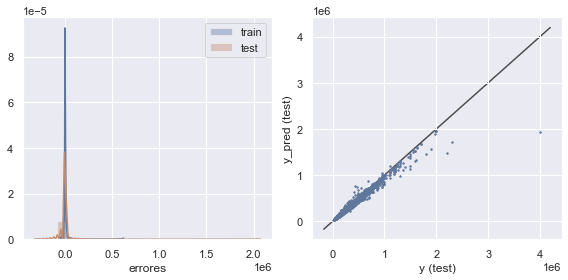

In [138]:
dist_errors(gridsearch_xgboost, 'GridSearch XGBRegressor')

In [156]:
gridsearch_xgboost.fit(X_train, y_train)
y_pred = gridsearch_xgboost.predict(X_test)
val_real = pd.Series(y_test.values)
val_pred = pd.Series(y_pred)

In [157]:
# Datos para el gráfico
preddf = pd.concat([val_real.rename('real'), val_pred.rename('pred')] ,  axis=1) # para el gráfico
# Datos para la tabla de diferencia
predicciones = pd.concat([val_real.rename('Valor Real'),val_pred.rename('Valor Pred') ,abs(val_real-val_pred).rename('Diferencia(+/-)')] ,  axis=1) # para mostrar en pantalla

In [158]:
predicciones.head(10)

,Valor Real,Valor Pred,Diferencia(+/-)
0,230000.00,235032.62,5032.62
1,170000.00,164592.17,5407.83
2,52000.00,56492.90,4492.90
3,420000.00,416543.38,3456.62
4,1700000.00,1676395.50,23604.50
5,125000.00,126061.88,1061.88
6,180000.00,176770.36,3229.64
7,430000.00,368081.62,61918.38
8,159000.00,157133.23,1866.77
9,139375.00,134589.33,4785.67


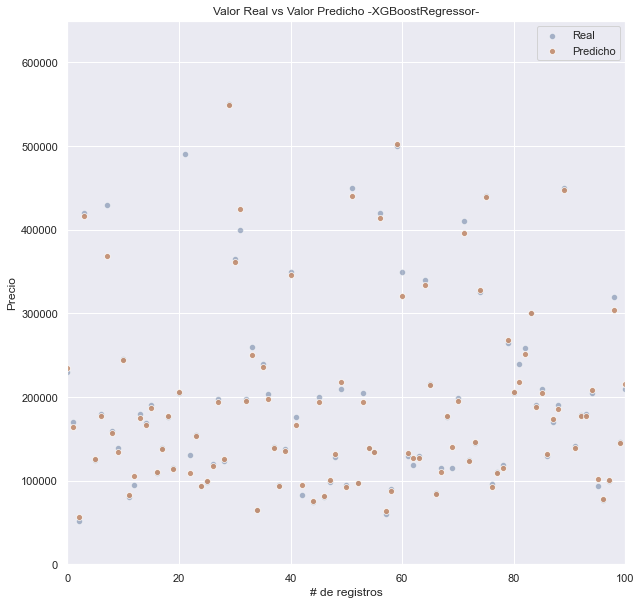

In [159]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(figsize = (10,10))

plt.xlim((0, 100)) # Mostramos los primeros n registros
plt.ylim((0, 650000)) # Limitamos la escala para mejorar visualización


sns.scatterplot(x = range(0, len(preddf), 1), y = "real", data = preddf, label = "Real", alpha = 0.5)
sns.scatterplot(x = range(0, len(preddf), 1), y = "pred", data = preddf, label = "Predicho", alpha = 0.9)

plt.title("Valor Real vs Valor Predicho -XGBoostRegressor-")
plt.ylabel('Precio')
plt.xlabel('# de registros')
plt.show()

## Lazy Predict

##### Lazy Predict ayuda a construir muchos modelos básicos sin mucho código y ayuda a comprender qué modelos funcionan mejor sin ningún ajuste de parámetros.  Esta vez utilizaremos la librería para obtener los resultados con los modelos de regresión que actualmente soporta e implementaremos como adicional el que nos muestra con menor resultado de RMSE.





In [142]:
# !pip install xgboost
# !pip install catboos
# !pip install lightgbm 
# pip install lazypredict

from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
import numpy as np

C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [143]:
# Realizar un Train/Test split de los datos.
X = dataML.drop(['price'], axis=1) # quitar la columna target
y = dataML['price'] # columna target

X_train, X_test, y_train, y_test = train_test_split (X,y, test_size=0.3, random_state = 2) #separar conjuntos 

In [144]:
reg = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 43/43 [07:51<00:00, 10.96s/it]


In [145]:
models

,R-Squared,RMSE,Time Taken
Model,,,
ExtraTreesRegressor,0.99,13218.86,8.22
XGBRegressor,0.99,14837.07,2.23
LGBMRegressor,0.99,15382.41,0.52
RandomForestRegressor,0.99,15665.74,10.32
GradientBoostingRegressor,0.99,15802.13,3.40
DecisionTreeRegressor,0.99,16119.64,0.22
BaggingRegressor,0.99,16409.02,0.89
HistGradientBoostingRegressor,0.98,18642.27,1.31
ExtraTreeRegressor,0.98,20116.60,0.17


### ExtraTreesRegressor

In [146]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=5, max_depth=10, max_features=0.3, n_jobs=-1, random_state=2)

In [147]:
model.fit(x_train, y_train)

ExtraTreesRegressor(max_depth=10, max_features=0.3, n_estimators=5, n_jobs=-1,
                    random_state=2)

In [148]:
#plot the importances
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:20]

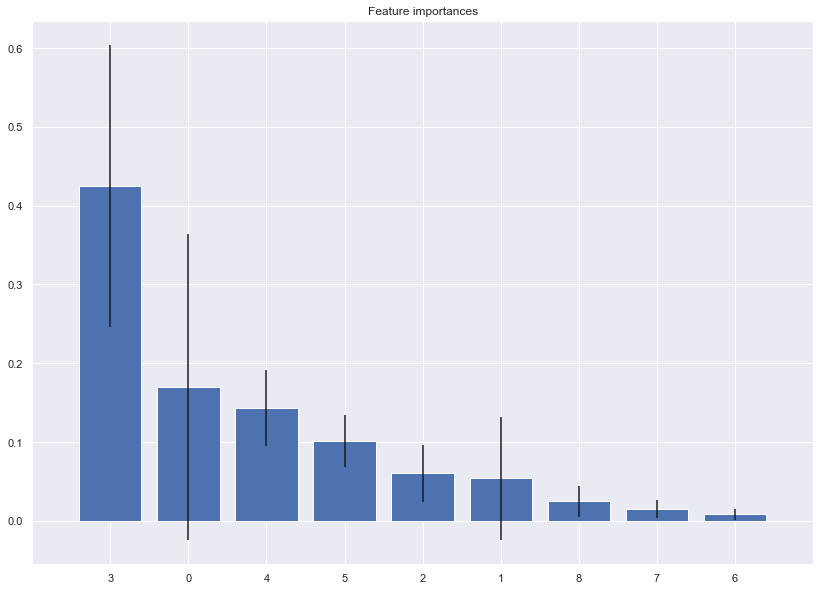

In [149]:
plt.figure(figsize=(14,10))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), indices)
plt.xlim([-1, len(indices)])
plt.show()

In [150]:
dataML.columns

Index(['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price_usd_x_m2', 'Property_type_0', 'Property_type_1',
       'Property_type_2', 'price'],
      dtype='object')

Modelo: ExtraTreesRegressor
Raíz del error cuadrático medio en Train: 43223.60237081596
Raíz del error cuadrático medio en Test: 47738.62471073488


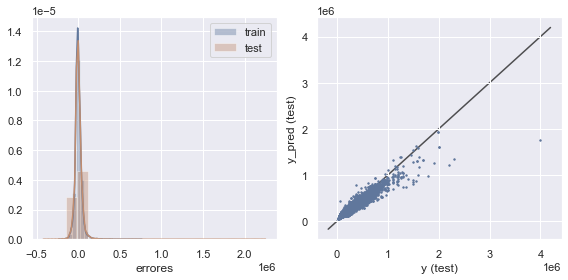

In [151]:
dist_errors(model, 'ExtraTreesRegressor')

In [152]:
from sklearn import model_selection
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = ensemble.ExtraTreesRegressor(n_estimators=5, max_depth=10, max_features=0.3, n_jobs=-1, random_state=2)
results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold)
print(results.mean())

0.8823029519539187


In [160]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
val_real = pd.Series(y_test.values)
val_pred = pd.Series(y_pred)

In [161]:
# Datos para el gráfico
preddf = pd.concat([val_real.rename('real'), val_pred.rename('pred')] ,  axis=1) # para el gráfico
# Datos para la tabla de diferencia
predicciones = pd.concat([val_real.rename('Valor Real'),val_pred.rename('Valor Pred') ,abs(val_real-val_pred).rename('Diferencia(+/-)')] ,  axis=1) # para mostrar en pantalla

In [162]:
predicciones.head(10)

,Valor Real,Valor Pred,Diferencia(+/-)
0,230000.00,223575.04,6424.96
1,170000.00,167074.68,2925.32
2,52000.00,76751.29,24751.29
3,420000.00,423882.32,3882.32
4,1700000.00,1317353.59,382646.41
5,125000.00,116223.04,8776.96
6,180000.00,167074.68,12925.32
7,430000.00,330860.02,99139.98
8,159000.00,149156.03,9843.97
9,139375.00,135102.03,4272.97


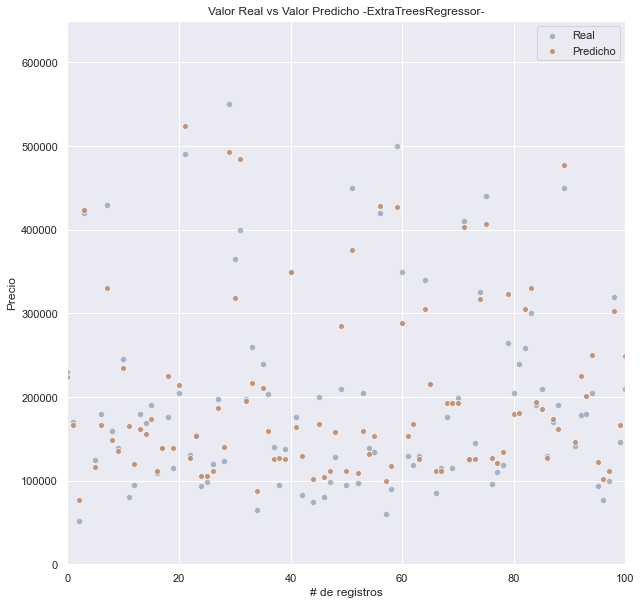

In [163]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(figsize = (10,10))

plt.xlim((0, 100)) # Mostramos los primeros n registros
plt.ylim((0, 650000)) # Limitamos la escala para mejorar visualización


sns.scatterplot(x = range(0, len(preddf), 1), y = "real", data = preddf, label = "Real", alpha = 0.5)
sns.scatterplot(x = range(0, len(preddf), 1), y = "pred", data = preddf, label = "Predicho", alpha = 0.9)

plt.title("Valor Real vs Valor Predicho -ExtraTreesRegressor-")
plt.ylabel('Precio')
plt.xlabel('# de registros')
plt.show()